# Criteria to select genes and cells

- eliminate proliferating cell types (not interested in proliferating cell states)
- remake the gene lists based on the DE new criteria (wilcox, pval threshold, sorted by logfc)

In [1]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns
#import scvelo as scv

#from matplotlib_venn import venn2
#import milopy.core as milo
#import milopy.plot as milopl

#pip install upsetplot
from upsetplot import from_contents
from upsetplot import UpSet

In [2]:
sc.settings.verbosity = 1

In [3]:
sc.set_figure_params(dpi=50, dpi_save=600) # Makes it more visible

In [4]:
#tmpfile = '../h5ad_files/MYELOID_ALL_wilcox_tmp.h5ad'

In [5]:
storage_folder = "/mnt/storage/Github/Immune_Adaptation_Atlas/h5ad_files/"

In [6]:
tmpfile = storage_folder + 'PAN.A01.v01.raw_count.20210429.MYELOID_V2.embedding.h5ad'
adata = sc.read_h5ad(tmpfile)
adata

AnnData object with n_obs × n_vars = 218758 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'leiden', 'scvi', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [7]:
adata

AnnData object with n_obs × n_vars = 218758 × 33538
    obs: 'n_counts', 'n_genes', 'file', 'mito', 'doublet_scores', 'predicted_doublets', 'old_annotation_uniform', 'organ', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Sample', 'scvi_clusters', 'is_maternal_contaminant', 'anno_lvl_2_final_clean', 'celltype_annotation'
    var: 'GeneID', 'GeneName', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'scvi_model_var'
    uns: 'leiden', 'scvi', 'umap'
    obsm: 'X_scvi', 'X_umap'
    obsp: 'scvi_connectivities', 'scvi_distances'

In [8]:
adata.obs["anno_lvl_2_final_clean"].cat.categories

Index(['AS_DC', 'CMP', 'CYCLING_DC', 'CYCLING_MEMP', 'CYCLING_MPP',
       'CYCLING_PDC', 'DC1', 'DC2', 'DC_PROGENITOR', 'DOUBLET_ERY_B',
       'EARLY_MK', 'EOSINOPHIL_BASOPHIL', 'FIBROBLAST_XVII', 'GMP', 'HSC_MPP',
       'LANGERHANS_CELLS', 'LMPP_MLP', 'LOW_QUALITY_MACROPHAGE',
       'MACROPHAGE_IRON_RECYCLING', 'MACROPHAGE_KUPFFER_LIKE',
       'MACROPHAGE_LYVE1_HIGH', 'MACROPHAGE_MHCII_HIGH',
       'MACROPHAGE_PROLIFERATING', 'MACROPHAGE_TREM2', 'MAST_CELL', 'MEMP',
       'MEP', 'MIGRATORY_DC', 'MONOCYTE_III_IL1B', 'MONOCYTE_II_CCR2',
       'MONOCYTE_I_CXCR4', 'MOP', 'MYELOCYTE', 'NEUTROPHIL', 'OSTEOCLAST',
       'PDC', 'PRE_DC2', 'PROMONOCYTE', 'PROMYELOCYTE'],
      dtype='object')

In [9]:
#sc.pl.umap(adata, color="anno_lvl_2_final_clean",save= "Lymphoid.png",legend_fontsize= 5  )

In [10]:
cells = [
 'CMP',
 'GMP',
 'PROMYELOCYTE',
 'MYELOCYTE',
 'NEUTROPHIL',
 'MOP',
 'PROMONOCYTE',
 'MONOCYTE_I_CXCR4',
 'MONOCYTE_II_CCR2',
 'MONOCYTE_III_IL1B',
 'DC_PROGENITOR',
 'PDC',
 #'CYCLING_PDC',
 'AS_DC',
 'PRE_DC2',
 #'CYCLING_DC',
 'DC2',
 'DC1',
 'MIGRATORY_DC',
 'LANGERHANS_CELLS',
 'EOSINOPHIL_BASOPHIL',
 'MAST_CELL',
 'MACROPHAGE_LYVE1_HIGH',
 'MACROPHAGE_IRON_RECYCLING',
 #'MACROPHAGE_PROLIFERATING',
 'MACROPHAGE_MHCII_HIGH',
 'MACROPHAGE_KUPFFER_LIKE',
 'MACROPHAGE_TREM2',
 'OSTEOCLAST'
]

In [11]:
adata = adata[adata.obs['anno_lvl_2_final_clean'].isin(cells)]

In [12]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=10e4)
sc.pp.log1p(adata)

/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


### Run DEG wilcox test

In [13]:
adata.obs['MAC_lyve1'] = ['MAC_lyve1' if i == "MACROPHAGE_LYVE1_HIGH" 
                          else 'rest' for i in adata.obs['anno_lvl_2_final_clean']]
adata.obs['MAC_lyve1'] = adata.obs['MAC_lyve1'].astype("category")

In [14]:
adatas = [adata[adata.obs['MAC_lyve1'].isin([clust])] for clust in adata.obs['MAC_lyve1'].cat.categories]
N = np.arange(0, adatas[0].n_obs, 1, dtype=int)
Ncells = 35001
del adata

## Subsample cells and test DEG again 

In [15]:
import random
from random import choices
random.seed(a=42, version=2)


In [16]:
samples = range(0,100)

#sample_sizes = [0.05, 0.01]
sample_sizes = [1, 0.5, 0.2, 0.1, 0.05, 0.01]
storage_folder = '~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/'

for i in samples:
    sample = "rep_%03d" % (i,)
    print(sample)
    CompleteList_DEgenes =  {}
    full_csv_path = storage_folder + "MAC_LYVE1_subsets_BOOTSTRAP_100_" + sample + ".csv"
    for s in sample_sizes :
        target_cells = int(Ncells * s)
        sample_name = "n_" + str(s) + "_" + sample
        #print(sample_name)
        
        # get the index of cells for each sample
        sample_idx = choices(N, k=target_cells)
        #if i > 47 and i < 50 :
        # create the full data with sampled cells
        a = adatas[0][sample_idx]
        a.obs_names_make_unique()
        adata_sample = a.concatenate(*adatas[1:])
        # test DE 
        sc.tl.rank_genes_groups(adata_sample, groupby= 'MAC_lyve1', method='wilcoxon',
                                key_added= "MAC_lyve1_sample_wilcox")
        # filter DE genes and sort them ny LogFC
        MAC_LYVE1_sample = sc.get.rank_genes_groups_df(adata_sample, group='MAC_lyve1',
                                                       key='MAC_lyve1_sample_wilcox',
                                                       pval_cutoff=0.0001, log2fc_min=1)
        MAC_LYVE1_sample = MAC_LYVE1_sample.sort_values("logfoldchanges", ascending=False)
        MAC_LYVE1_sample.reset_index(drop=True, inplace=True)
        # export DE_genes with sample name
        CompleteList_DEgenes[sample_name] = MAC_LYVE1_sample["names"]
        del(a)
    #if i > 47 and i < 50 :
    (pd.DataFrame.from_dict(data=CompleteList_DEgenes, orient='index').to_csv(full_csv_path, header=False))

rep_000
rep_001
rep_002
rep_003
rep_004
rep_005
rep_006
rep_007
rep_008
rep_009
rep_010
rep_011
rep_012
rep_013
rep_014
rep_015
rep_016
rep_017
rep_018
rep_019
rep_020
rep_021
rep_022
rep_023
rep_024
rep_025
rep_026
rep_027
rep_028
rep_029
rep_030
rep_031
rep_032
rep_033
rep_034
rep_035
rep_036
rep_037
rep_038
rep_039
rep_040
rep_041
rep_042
rep_043
rep_044
rep_045
rep_046
rep_047
rep_048


/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype 

rep_049


/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/irepan/anaconda3/envs/pyscenic/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype 

rep_050
rep_051
rep_052
rep_053
rep_054
rep_055
rep_056
rep_057
rep_058
rep_059
rep_060
rep_061
rep_062
rep_063
rep_064
rep_065
rep_066
rep_067
rep_068
rep_069
rep_070
rep_071
rep_072
rep_073
rep_074
rep_075
rep_076
rep_077
rep_078
rep_079
rep_080
rep_081
rep_082
rep_083
rep_084
rep_085
rep_086
rep_087
rep_088
rep_089
rep_090
rep_091
rep_092
rep_093
rep_094
rep_095
rep_096
rep_097
rep_098
rep_099


## Open the saved lists to create individual lists with Ensemble IDs

~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_BOOTSTRAP_100_rep_000.csv
~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_BOOTSTRAP_100_rep_001.csv
~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_BOOTSTRAP_100_rep_002.csv
~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_BOOTSTRAP_100_rep_003.csv
~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_BOOTSTRAP_100_rep_004.csv
~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_BOOTSTRAP_100_rep_005.csv
~/Desktop/

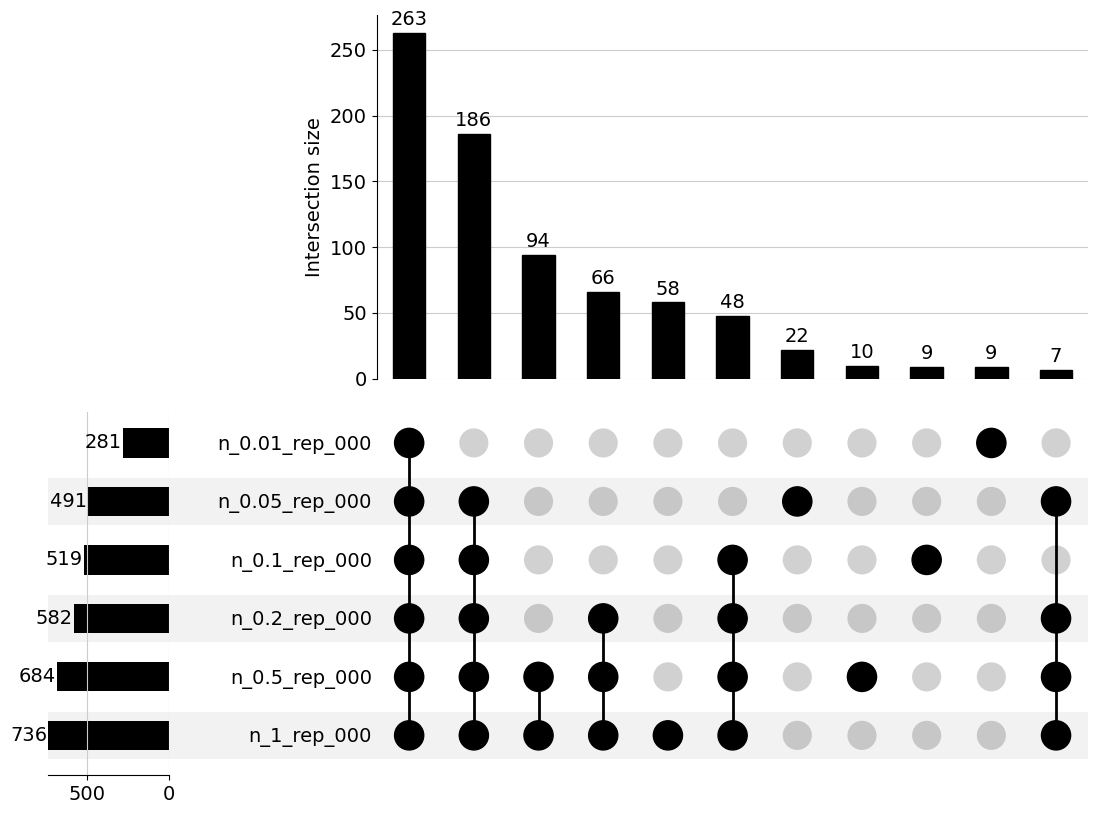

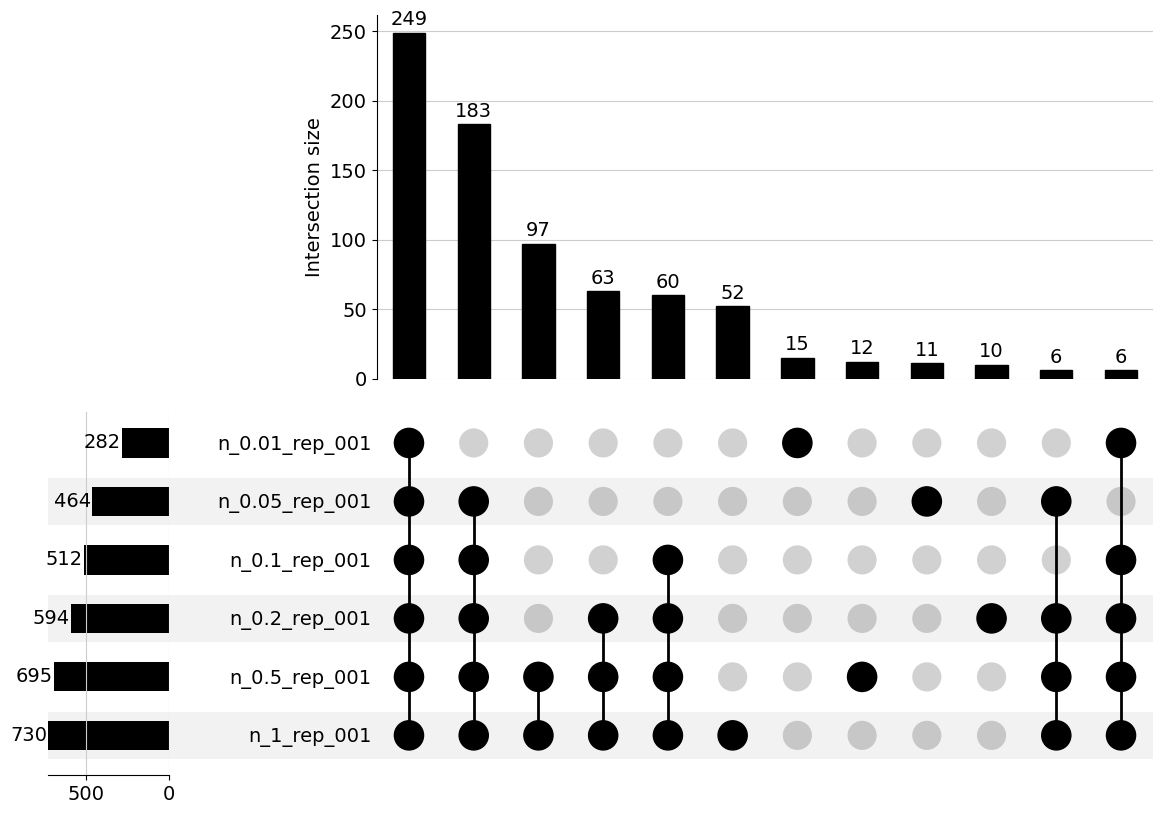

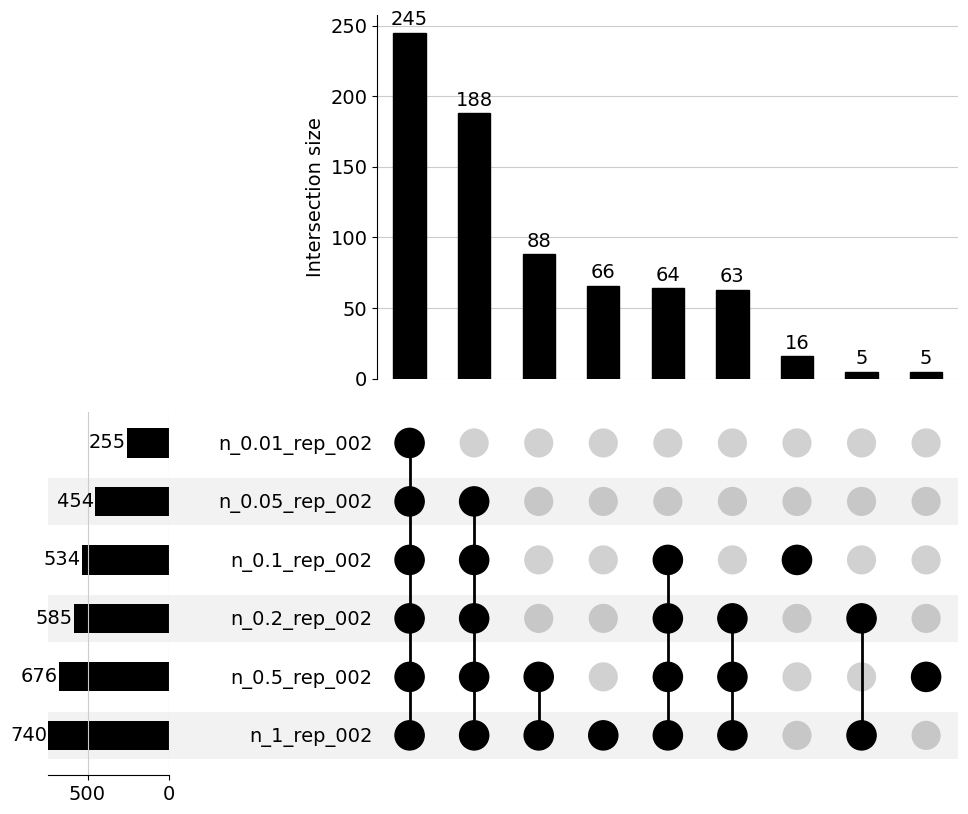

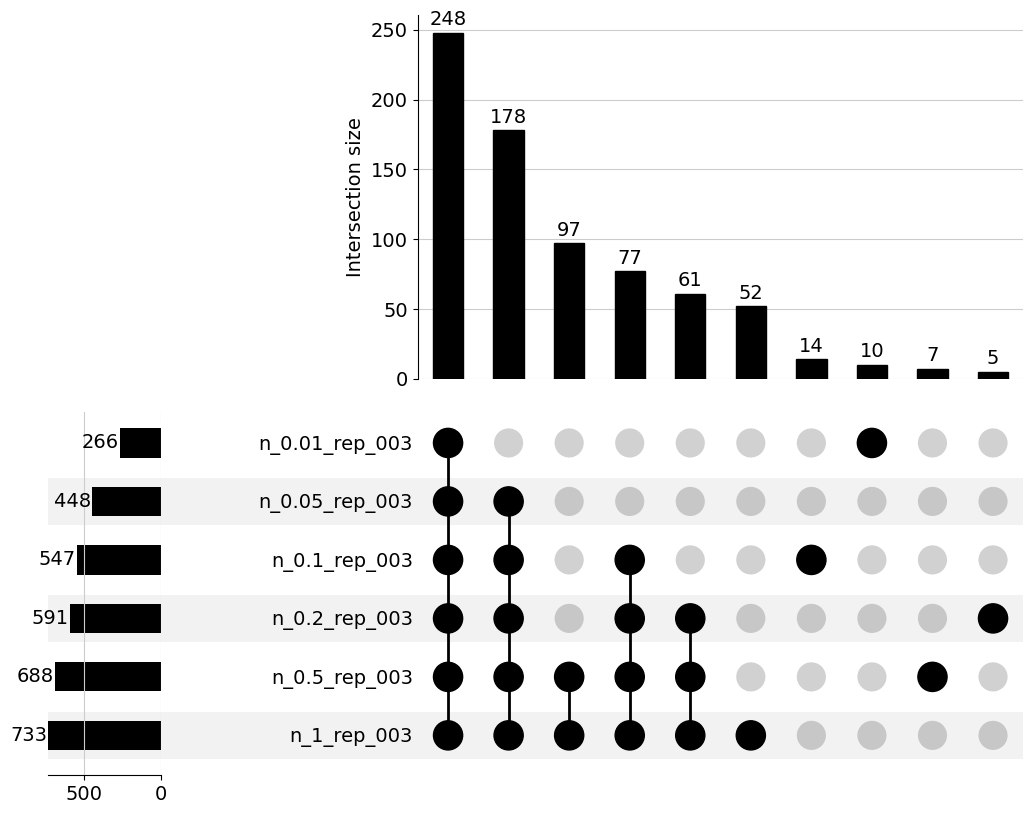

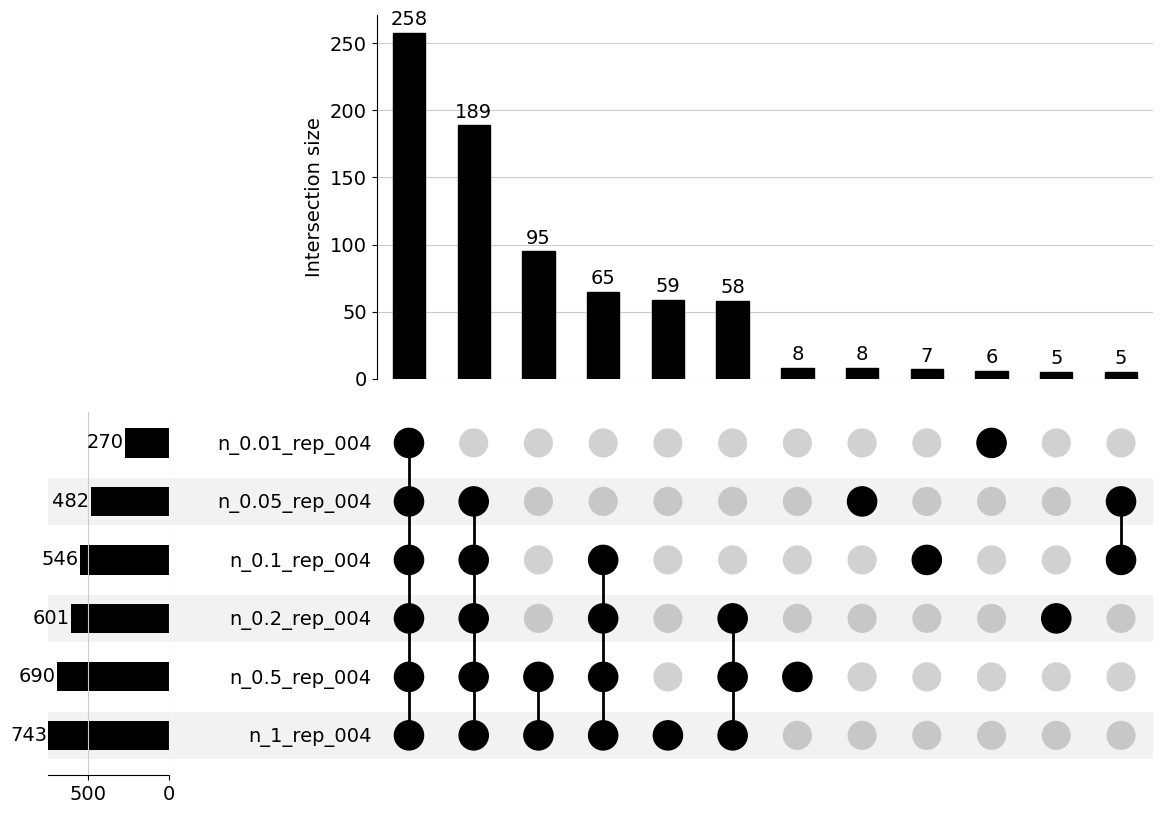

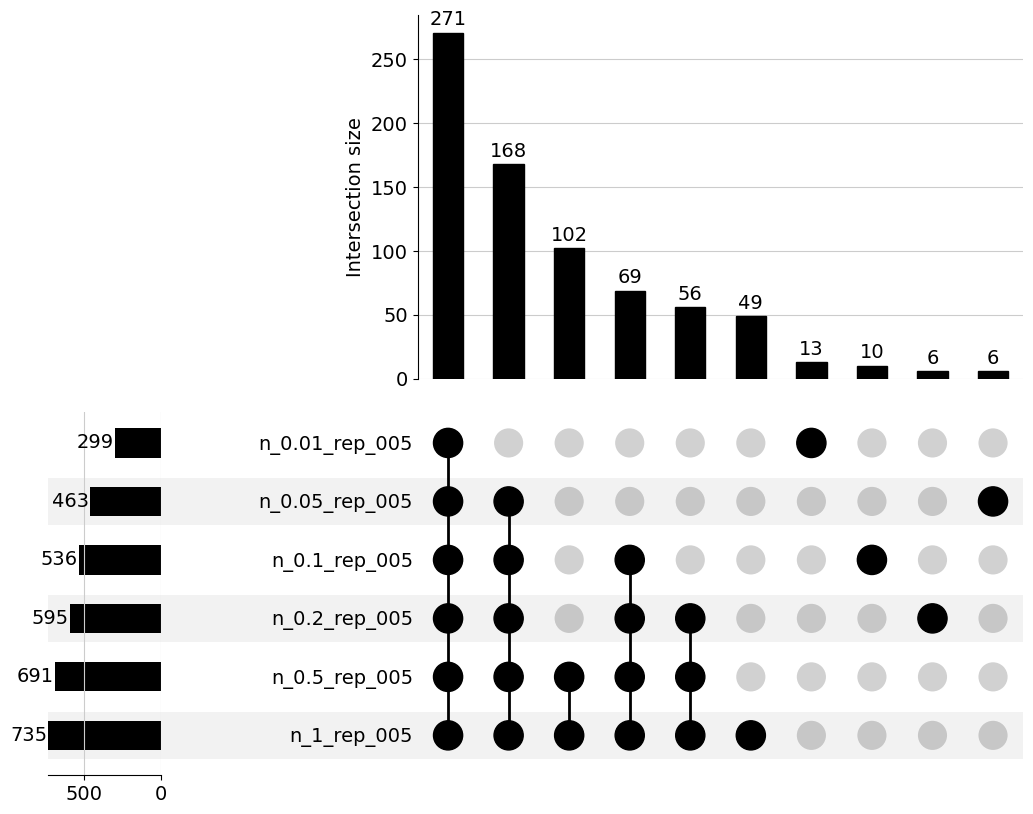

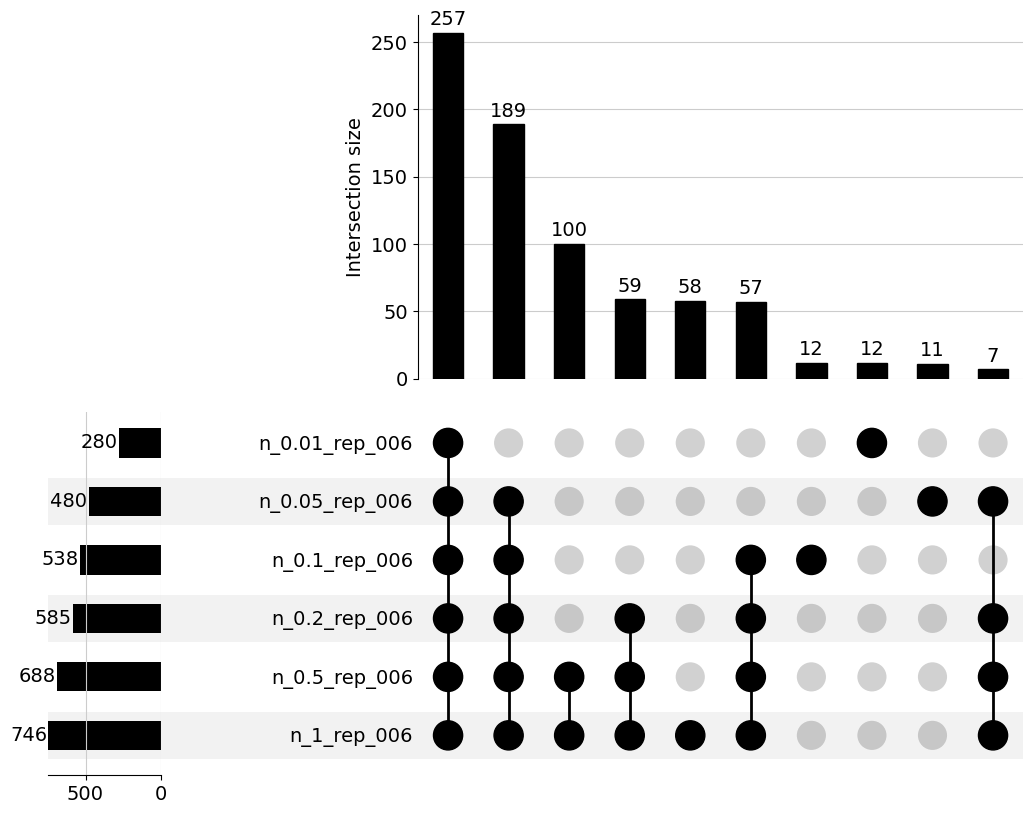

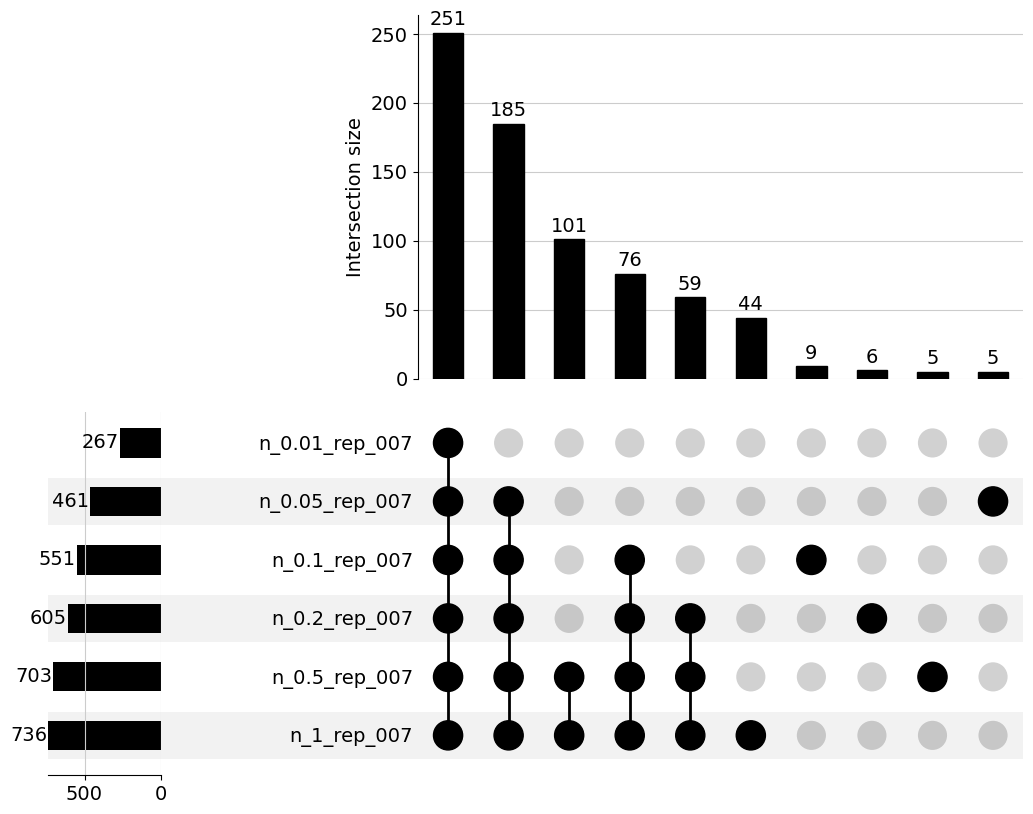

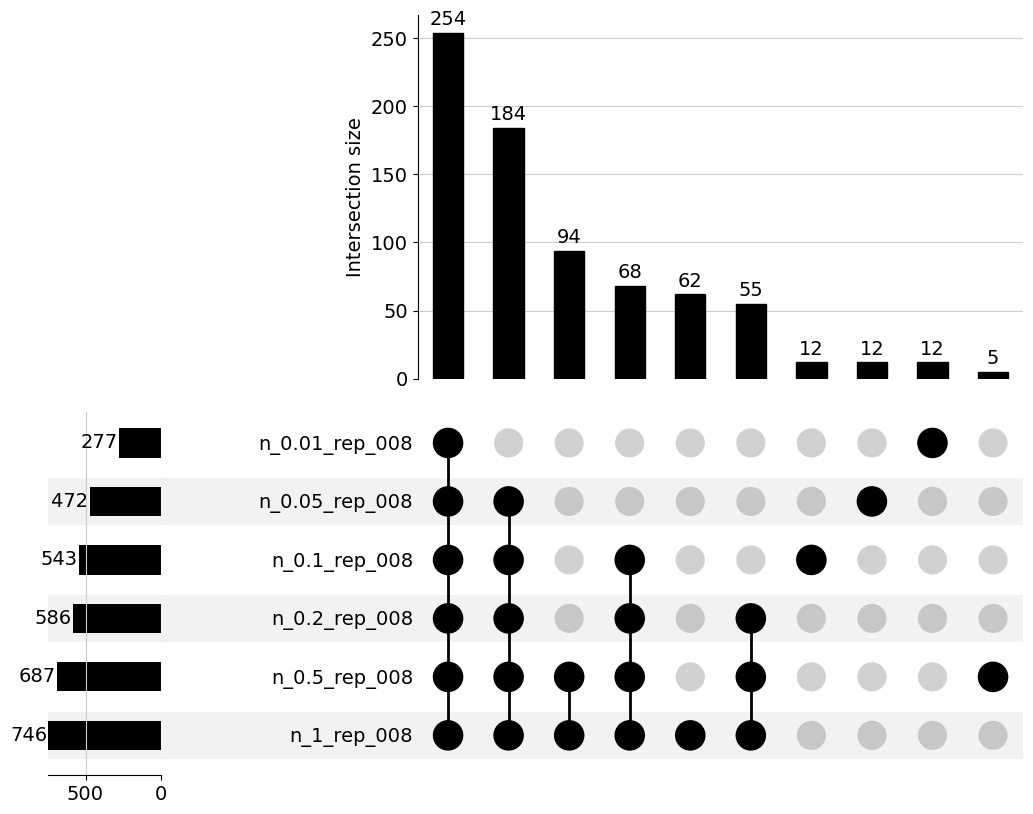

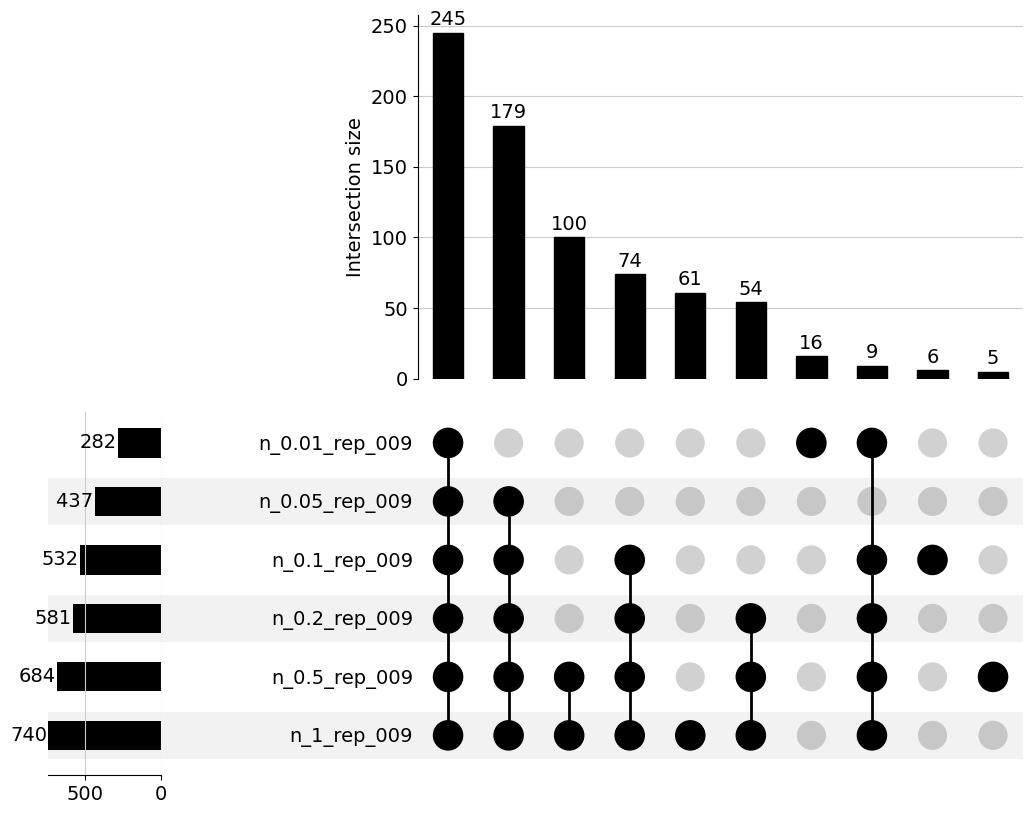

In [6]:
storage_folder = '~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/'

for i in  range(0,10):
    sample = "rep_%03d" % (i,)
    CompleteList_DEgenes =  {}
    full_csv_path = storage_folder + "MAC_LYVE1_subsets_BOOTSTRAP_100_" + str(sample) + ".csv"
    print(full_csv_path)
    df = pd.read_csv(full_csv_path, header=None, index_col=0)
    for j in range(0,6):
        d = df.iloc[j].dropna()
        CompleteList_DEgenes[d.name] = d.values
    
    CompleteList_DEgenes
    CT_markers = from_contents(CompleteList_DEgenes)
    plt = UpSet(CT_markers, min_subset_size=5, show_percentages=False, sort_by="cardinality",
                subset_size='count',element_size=60,  show_counts=True).plot()

~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_BOOTSTRAP_100_rep_000.csv
~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_BOOTSTRAP_100_rep_001.csv
~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_BOOTSTRAP_100_rep_002.csv
~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_BOOTSTRAP_100_rep_003.csv
~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_BOOTSTRAP_100_rep_004.csv
~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_BOOTSTRAP_100_rep_005.csv
~/Desktop/

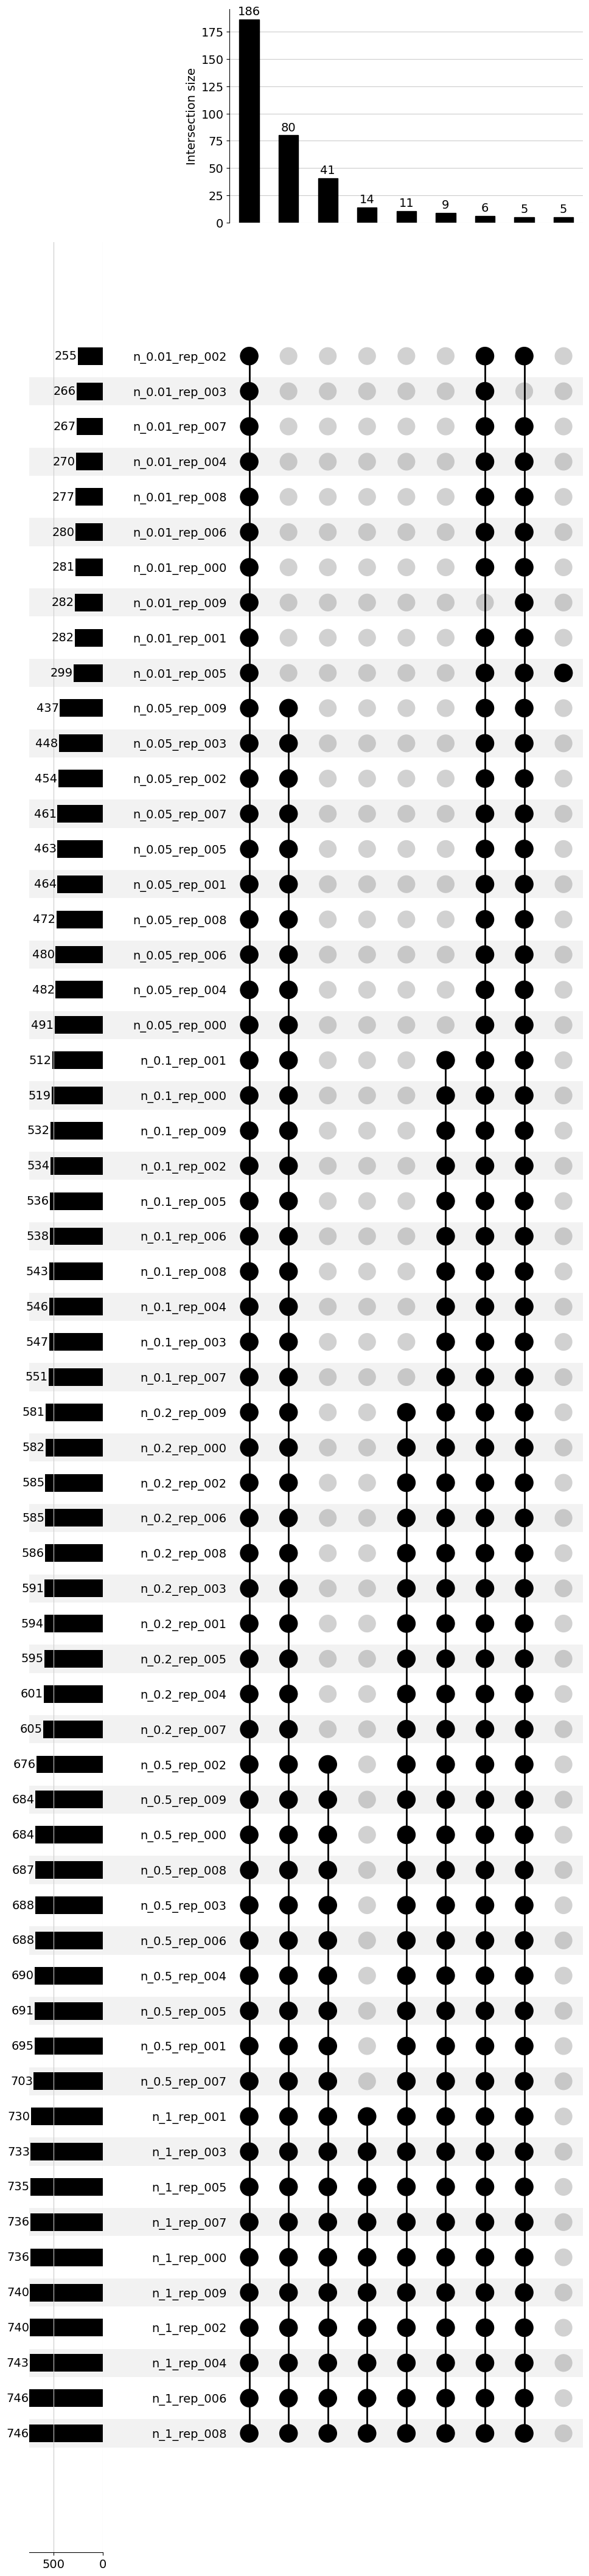

In [7]:
CompleteList_DEgenes =  {}

for i in  range(0,10):
    sample = "rep_%03d" % (i,)
    full_csv_path = storage_folder + "MAC_LYVE1_subsets_BOOTSTRAP_100_" + str(sample) + ".csv"
    print(full_csv_path)
    df = pd.read_csv(full_csv_path, header=None, index_col=0)
    for j in range(0,6):
        d = df.iloc[j].dropna()
        CompleteList_DEgenes[d.name] = d.values
    
#CompleteList_DEgenes
CT_markers = from_contents(CompleteList_DEgenes)
plt = UpSet(CT_markers, min_subset_size=5, show_percentages=False, sort_by="cardinality",
            subset_size='count',element_size=60,  show_counts=True).plot()

In [8]:
%load_ext rpy2.ipython
full_csv_path =  '~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/'


In [13]:
%%R -i full_csv_path
library("EnsDb.Hsapiens.v86")
library(stringr)

out_path <- paste0(full_csv_path, "Bootstrap_samples_100/MAC_LYVE1_subsets_BOOTSTRAP_")

for (j in 0:99)
    {
    sample = sprintf("rep_%.3d", j)
    infile <- paste0(full_csv_path,"MAC_LYVE1_subsets_BOOTSTRAP_100_",sample,".csv")
    print(infile)
    mycsv <- read.csv(infile,
                      row.names = 1,header = F, na.strings = "")
    list_genes <- list()
    for (i in 1:nrow(mycsv))
        {
        genelist <- row.names(mycsv)[i]

        f <- str_remove_all(genelist, "[()]")
        #print(f)
        
        n <- sum(!is.na(mycsv[i,]))
        #print(paste0(n," genes"))
        
        goi <- as.character(mycsv[i,1:n])
        #print(goi[1:5])

        ens_df <- ensembldb::select(EnsDb.Hsapiens.v86, keys= goi, 
                                  keytype = "SYMBOL", 
                                  columns = c("SYMBOL","GENEID"))
       
        ens_df <- ens_df$GENEID[grepl(pattern = "^ENS", x = ens_df$GENEID)]
        #print(head(ens_df)) 
        list_genes[[f]]<- ens_df
        
        write(x = ens_df, file = paste0(out_path, f ,"_FULL_ENSEMBL.txt"),ncolumns = 1)
    
        }
    }


[1] "~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_BOOTSTRAP_100_rep_000.csv"
[1] "~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_BOOTSTRAP_100_rep_001.csv"
[1] "~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_BOOTSTRAP_100_rep_002.csv"
[1] "~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_BOOTSTRAP_100_rep_003.csv"
[1] "~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_BOOTSTRAP_100_rep_004.csv"
[1] "~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_B

[1] "~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_BOOTSTRAP_100_rep_094.csv"
[1] "~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_BOOTSTRAP_100_rep_095.csv"
[1] "~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_BOOTSTRAP_100_rep_096.csv"
[1] "~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_BOOTSTRAP_100_rep_097.csv"
[1] "~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_BOOTSTRAP_100_rep_098.csv"
[1] "~/Desktop/Github/Immune_Adaptation_Atlas_2023/Developmental/ENS_FULL_genelists_wilcox/Myeloid_ALL/MACRO_LYVE1_downsample/MAC_LYVE1_subsets_B